In [ ]:
!cp -r 'drive/MyDrive/study/Skoltech/NLA_Project' '.'
#!cp -r 'drive/MyDrive/nla/quora-question-pairs' '.'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install einops
!pip install local-attention
!pip install pytorch-fast-transformers
!pip install axial-positional-embedding
!pip install product-key-memory
!pip install youtokentome

# Quora without pretraining experiment (Failed)

In [ ]:
import pandas as pd
import numpy as np
import torch
import argparse
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm
from NLA_Project.general_transformer import GenearalTransformer
import youtokentome as yttm
from functools import partial
from scipy.optimize import minimize
import os
import re
import string

In [ ]:
MODEL_TYPE = 'linformer'

VOCAB_SIZE = 5000
N_HEADS = 12
N_LAYERS = 4
D_MODEL = 480
EPOCHS = 10
BATCH_SIZE = 75
LR = 0.01
SEQ_LEN = 150

SEED = 42

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am",'i\'m':'i am', "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled'}

In [ ]:
def clean_contractions(text, mapping):
    text = text.lower()
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else mapping[t.lower()] if t.lower() in mapping else t for t in text.split(" ")])
    return text

In [ ]:
def train_bpe_tokenizer(df, tokenizer_filename, vocab_size):
    with open('NLA_Project/data/train.txt', 'w') as fout:
        for col in ['question1', 'question2']:
            for question in df[col]:
                print(question, file=fout)
    yttm.BPE.train(data='NLA_Project/data/train.txt', vocab_size=vocab_size, model=tokenizer_filename)
    os.remove('NLA_Project/data/train.txt')

def preprocess_string(s):
    s = s.lower()
    s = ' '.join([re.sub('[\W]', '', part) for part in re.split(f'[{string.whitespace}]', s)])
    return s

train = pd.read_csv('NLA_Project/data/train.csv')
train = train[np.logical_not((np.logical_or(train['question1'].isna(), train['question2'].isna())))]
train['question1'] = train['question1'].apply(lambda x: clean_contractions(x, contraction_mapping))
train['question2'] = train['question2'].apply(lambda x: clean_contractions(x, contraction_mapping))
  
train_ratio = 0.8
thresh_ratio = 0.35

train, val = train_test_split(train, train_size=train_ratio, random_state=SEED)
thresh, val = train_test_split(val, train_size=thresh_ratio, random_state=SEED)

#train['question1'] = train['question1'].str.lower()
#train['question2'] = train['question2'].str.lower()

train_bpe_tokenizer(train, f'tokenizer{VOCAB_SIZE}.model', VOCAB_SIZE)
tokenizer = yttm.BPE(model=f'tokenizer{VOCAB_SIZE}.model')

In [ ]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
174950,174950,269495,269496,india: what are job options and future options...,jobs and careers in india: i am currently in m...,0
119443,119443,155654,84312,which is world's best romantic movie?,what is the best romantic movie of all time?,1
252943,252943,367382,367383,which is best place to live in hyderabad?,which is best place to live hyderabad or mumbai?,0
13551,13551,26006,26007,what should i do to be an athlete in a month?,what is shop act licence?,0
274898,274898,393592,364189,how do you learn to code on wordpress?,in how much time can i learn to code a wordpre...,1


In [ ]:
class PairsDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer
    
    def __getitem__(self, id):
        row = self.data.iloc[id]
        q1, q2 = row.question1, row.question2
        q1 = torch.LongTensor([1] + self.tokenizer.encode(q1))
        q2 = torch.LongTensor([1] + self.tokenizer.encode(q2))
        target = row.is_duplicate
        
        return q1, q2, target
    
    def __len__(self):
        return len(self.data)
    

def collate_fn(batch):
    q1, q2, targets = zip(*batch)
    q1 = pad_sequence(q1, batch_first=True)
    q2 = pad_sequence(q2, batch_first=True)
    targets = torch.LongTensor(targets)

    if q1.shape[1] > SEQ_LEN:
      q1 = q1[:, :SEQ_LEN]
    if q2.shape[1] > SEQ_LEN:
      q2 = q2[:, :SEQ_LEN]
    
    return q1, q2, targets

train_loader = DataLoader(PairsDataset(train, tokenizer), 
                          batch_size=BATCH_SIZE, 
                          shuffle=True,
                          drop_last=True,
                          collate_fn=collate_fn)

thresh_loader = DataLoader(PairsDataset(thresh, tokenizer), 
                           batch_size=BATCH_SIZE,
                           collate_fn=collate_fn)

val_loader = DataLoader(PairsDataset(val, tokenizer), 
                        batch_size=BATCH_SIZE,
                        collate_fn=collate_fn)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class SiameseTransformer(nn.Module):
    def __init__(self, model, d, reduction='mean'):
        super(SiameseTransformer, self).__init__()
        self.model = model
        self.classifier = nn.Linear(2 * d, 1)
        assert(reduction in ['mean', 'cls'], 'Invalid reduction mode')
        self.reduction = reduction
        self.dropout = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()
        
    def _embed(self, x, mask):
        x = self.model(x, mask)

        if self.reduction == 'mean':
            x = x.masked_fill(~mask[..., None], 0).sum(1) / mask.sum(1)[:, None]
        elif self.reduction == 'max':
            x = x.masked_fill(~mask[..., None], 0).max(1)[0]
        else:
            x = x[:, 0, :]
        return x
        
    def forward(self, q1, mask1, q2, mask2):
        q1 = self._embed(q1, mask1)
        q2 = self._embed(q2, mask2)
        #q1 = self.dropout(q1)
        #q2 = self.dropout(q2)
        
        embedding = torch.cat([q1, q2], axis=-1)
        logits = self.classifier(embedding)
        return self.sigmoid(logits)
    
    def compute_similarity(self, q1, mask1, q2, mask2):
        q1 = self._embed(q1, mask1)
        q2 = self._embed(q2, mask2)
        sim = F.cosine_similarity(q1, q2)
        return sim


class OptimizedRounder:
    """
    An optimizer for rounding thresholds
    to maximize F1 score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """
    def __init__(self, initial_coef=0.5):
        self.thresh = None
        self.initial_coef = initial_coef

    def _f_score_loss(self, threshold, similarities, trues):
        """
        Get loss according to
        using current coefficients
        
        :param threshold: Prediction threshold
        :param similarities: Predicted cosine similarities
        :param true: The ground truth labels
        """
        preds = pd.cut(similarities, [-np.inf] + list(threshold) + [np.inf], labels = [0, 1])

        return -f1_score(trues, preds)

    def fit(self, similarities, trues):
        """
        Optimize prediction threshold
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._f_score_loss, similarities=similarities, trues=trues)
        self.thresh = minimize(loss_partial, self.initial_coef, method='nelder-mead')['x']

    def predict(self, similarities):
        """
        Make predictions with optimized threshold
        
        :param threshold: Prediction threshold
        :param similarities: Predicted cosine similarities
        """
        return pd.cut(similarities, [-np.inf] + list(self.thresh) + [np.inf], labels = [0, 1])

class F1_Loss(nn.Module):
    '''Calculate F1 score. Can work with gpu tensors
    
    The original implmentation is written by Michal Haltuf on Kaggle.
    
    Returns
    -------
    torch.Tensor
        `ndim` == 1. epsilon <= val <= 1
    
    Reference
    ---------
    - https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
    - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
    - https://discuss.pytorch.org/t/calculating-precision-recall-and-f1-score-in-case-of-multi-label-classification/28265/6
    - http://www.ryanzhang.info/python/writing-your-own-loss-function-module-for-pytorch/
    '''
    def __init__(self, epsilon=1e-7):
        super().__init__()
        self.epsilon = epsilon
        
    def forward(self, y_pred, y_true,):
        assert y_pred.ndim == 2
        assert y_true.ndim == 1
        y_true = F.one_hot(y_true, 2).to(torch.float32)
        y_pred = F.softmax(y_pred, dim=1)
        
        tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)

        f1 = 2* (precision*recall) / (precision + recall + self.epsilon)
        f1 = f1.clamp(min=self.epsilon, max=1-self.epsilon)
        return 1 - f1.mean()

<ipython-input-21-ad05a5dd0189>:6: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(reduction in ['mean', 'cls'], 'Invalid reduction mode')


In [ ]:
transformer = GenearalTransformer(MODEL_TYPE, VOCAB_SIZE, SEQ_LEN, D_MODEL, N_HEADS, N_LAYERS)
model = SiameseTransformer(transformer, D_MODEL, reduction='mean')
#optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#criterion = torch.nn.CrossEntropyLoss()
#criterion = F1_Loss().cuda()
criterion = torch.nn.BCELoss()
model.to(device)

SiameseTransformer(
  (model): GenearalTransformer(
    (encoder): LinformerLM(
      (to_token_emb): Embedding(5000, 480)
      (pos_emb): PositionalEmbedding()
      (linformer): Linformer(
        (seq): ModuleList(
          (0): Residual(
            (fn): MHAttention(
              (heads): ModuleList(
                (0): LinearAttentionHead(
                  (E): Linear(in_features=150, out_features=64, bias=True)
                  (F): Linear(in_features=150, out_features=64, bias=True)
                  (dropout): Dropout(p=0.05, inplace=False)
                )
                (1): LinearAttentionHead(
                  (E): Linear(in_features=150, out_features=64, bias=True)
                  (F): Linear(in_features=150, out_features=64, bias=True)
                  (dropout): Dropout(p=0.05, inplace=False)
                )
                (2): LinearAttentionHead(
                  (E): Linear(in_features=150, out_features=64, bias=True)
                  (F): Linear(in_

In [ ]:
best_f1 = 0

for epoch in range(EPOCHS):
    model.train()
    losses = []
    for q1, q2, targets in tqdm(train_loader):
        optimizer.zero_grad()

        q1 = F.pad(q1, (0, SEQ_LEN - q1.size(1), 0, 0))
        q2 = F.pad(q2, (0, SEQ_LEN - q2.size(1), 0, 0))
        q1, q2, targets = q1.to(device), q2.to(device), targets.to(device)
    
        mask1, mask2 = q1 != 0, q2 != 0
        logits = model(q1, mask1, q2, mask2).flatten()
        loss = criterion(logits, targets.type(torch.FloatTensor).cuda())
        #print(loss.detach().cpu().numpy())
        losses.append(loss.item())
    
        loss.backward()
        optimizer.step()
    
    print('Average loss', np.mean(losses))
    model.eval()
    with torch.no_grad():
        similarities = []
        trues = []
        
        for q1, q2, targets in thresh_loader:
            q1 = F.pad(q1, (0, SEQ_LEN - q1.size(1), 0, 0))
            q2 = F.pad(q2, (0, SEQ_LEN - q2.size(1), 0, 0))
            q1, q2 = q1.to(device), q2.to(device)
            mask1, mask2 = q1 != 0, q2 != 0
            sim = model.compute_similarity(q1, mask1, q2, mask2)
            similarities.extend(sim.cpu().numpy().tolist())
            trues.extend(targets.numpy().tolist())
        
        threshold_tuner = OptimizedRounder(0.5)
        threshold_tuner.fit(similarities, trues)
        
        similarities = []
        trues = []
        
        for q1, q2, targets in val_loader:
            q1 = F.pad(q1, (0, SEQ_LEN - q1.size(1), 0, 0))
            q2 = F.pad(q2, (0, SEQ_LEN - q2.size(1), 0, 0))
            q1, q2 = q1.to(device), q2.to(device)
            mask1, mask2 = q1 != 0, q2 != 0
            sim = model.compute_similarity(q1, mask1, q2, mask2)
            similarities.extend(sim.cpu().numpy().tolist())
            trues.extend(targets.numpy().tolist())
        
        preds = threshold_tuner.predict(similarities)
        f1 = f1_score(trues, preds)
        print(f'Epoch: {epoch + 1}, f1: {f1}')
        
        if f1 > best_f1:
            best_f1 = f1
            torch.save({'model': model.state_dict(),
                        'f1': f1,
                        'threshold': threshold_tuner.thresh},
                        f'{MODEL_TYPE}_epoch{epoch + 1}.pth')


Average loss 0.6642302654282723
Epoch: 1, f1: 0.5424645377778394



Average loss 0.6602818937989466
Epoch: 2, f1: 0.5424645377778394



Average loss 0.6344084149720718
Epoch: 3, f1: 0.5436727600411947


__The score is too low to be a good result__

# Benchmarks

In [ ]:
import pandas as pd
import numpy as np
import torch
import argparse
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm
from NLA_Project.general_transformer import GenearalTransformer
import youtokentome as yttm
from functools import partial
from scipy.optimize import minimize
import os
import re
import string

## Experiment setup

In [ ]:
import sys
def get_model_weight(model):
    weight = 0
    for p in model.parameters():
        weight += sys.getsizeof(p.storage())
    return weight

In [ ]:
from time import time
import timeit

seq_len_to_speed_tf = []
seq_len_to_memory_tf = []
seq_lens = [8, 16, 32, 64, 128, 256, 512, 1024]
model_type = 'transformer'

for seq_len in seq_lens:

    parameters = {
        'VOCAB_SIZE': 5000,
        'N_HEADS': 8,
        'N_LAYERS': 1,
        'D_MODEL': 512,
        'SEQ_LEN': seq_len,
        'N_SAMPLES': 25,
        'MASKED': True}

    print('Model initialization')
    transformer = GenearalTransformer(model_type, parameters['VOCAB_SIZE'], parameters['SEQ_LEN'], 
                                      parameters['D_MODEL'], parameters['N_HEADS'], parameters['N_LAYERS'])
    print('Model initialized')
        
    size = get_model_weight(transformer)

    data = torch.randint(0, parameters['VOCAB_SIZE'], (parameters['N_SAMPLES'], parameters['SEQ_LEN']))
    mask = data != 0

    if parameters['MASKED']:
        t = time()
        for i in range(20):
            transformer(data, mask)
        speed = (time() - t) / 20
    else:
        t = time()
        for i in range(20):
            transformer(data, None)
        speed = (time() - t) / 20

    del data, mask

    print(f'{model_type} complete! Sequence length: {seq_len} \t Time taken: {speed} \t Model size: {size}')

    seq_len_to_speed_tf.append(speed)
    seq_len_to_memory_tf.append(size)

Model initialization
Model initialized
transformer complete! Sequence length: 8 	 Time taken: 0.03672041893005371 	 Model size: 22854848
Model initialization
Model initialized
transformer complete! Sequence length: 16 	 Time taken: 0.05379307270050049 	 Model size: 22854848
Model initialization
Model initialized
transformer complete! Sequence length: 32 	 Time taken: 0.10594406127929687 	 Model size: 22854848
Model initialization
Model initialized
transformer complete! Sequence length: 64 	 Time taken: 0.22439055442810057 	 Model size: 22854848
Model initialization
Model initialized


KeyboardInterrupt: ignored

In [1]:
seq_lens_tf = [8, 16, 32, 64, 128, 256, 512, 1024]

tf_logs = {
    'seq_lens_tf': seq_lens_tf,
    'times_tf': seq_len_to_speed_tf,
    'memory_tf': seq_len_to_memory_tf
}

import json
with open('tf_logs.json', 'w') as file:
    json.dump(tf_logs, file)

NameError: ignored

In [ ]:
seq_lens_lf = [8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]

lf_logs = {
    'seq_lens_lf': seq_lens_lf,
    'times_lf': seq_len_to_speed_lf,
    'memory_lf': seq_len_to_memory_lf
}

import json
with open('lf_logs.json', 'w') as file:
    json.dump(lf_logs, file)

In [ ]:
seq_lens_pf = [8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]

pf_logs = {
    'seq_lens_pf': seq_lens_pf,
    'times_pf': seq_len_to_speed_pf,
    'memory_pf': seq_len_to_memory_pf
}

import json
with open('pf_logs.json', 'w') as file:
    json.dump(pf_logs, file)

In [3]:
import json
with open('tf_logs.json', 'r') as file:
    tf_logs = json.load(file)
with open('pf_logs.json', 'r') as file:
    pf_logs = json.load(file)
with open('lf_logs.json', 'r') as file:
    lf_logs = json.load(file)

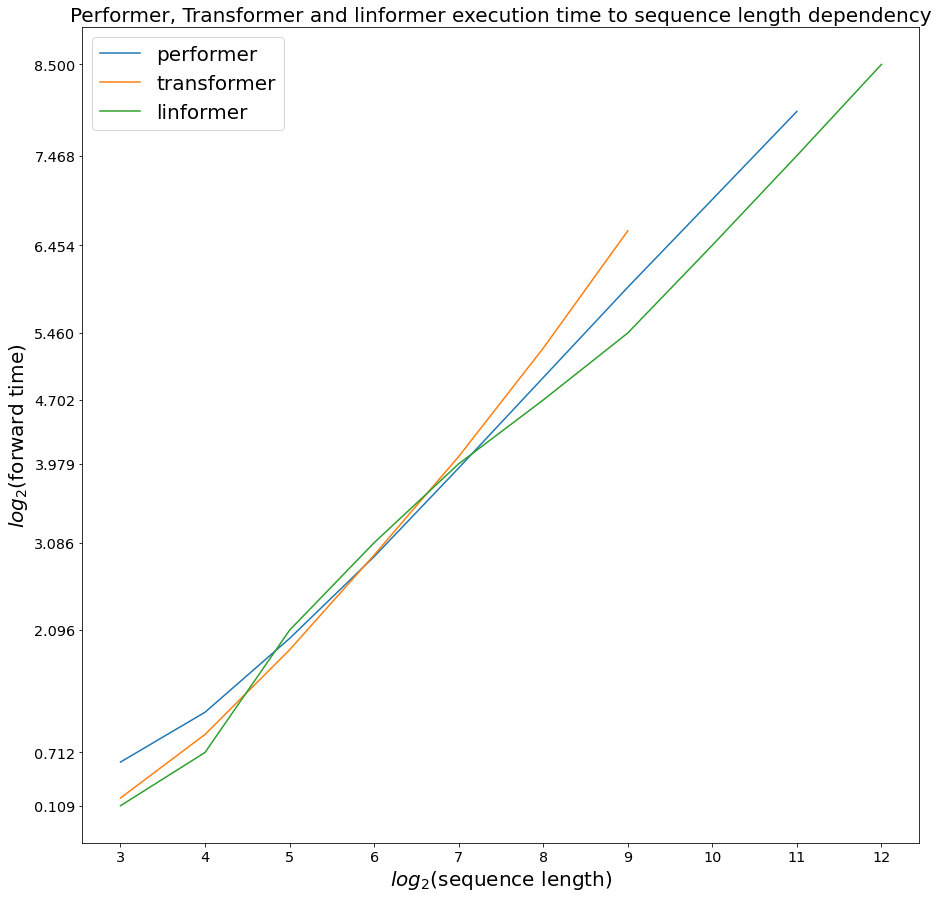

In [15]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(15,15))

plt.title('Performer, Transformer and linformer execution time to sequence length dependency', fontsize=20)
plt.xlabel('$log_2$(sequence length)', fontsize=20)
plt.ylabel('$log_2$(forward time)', fontsize=20)
plt.plot(np.log2(pf_logs['seq_lens_pf']), np.log2(np.array(pf_logs['times_pf'])), label='performer')
plt.plot(np.log2(tf_logs['seq_lens_tf']), np.log2(np.array(tf_logs['times_tf'])), label='transformer')
plt.plot(np.log2(lf_logs['seq_lens_lf']), np.log2(np.array(lf_logs['times_lf'])), label='linformer')

params = {'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

plt.xticks(np.log2(lf_logs['seq_lens_lf']))
plt.yticks(np.log2(np.array(lf_logs['times_lf'])))
plt.legend(prop={'size': 20})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log2
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log2
  


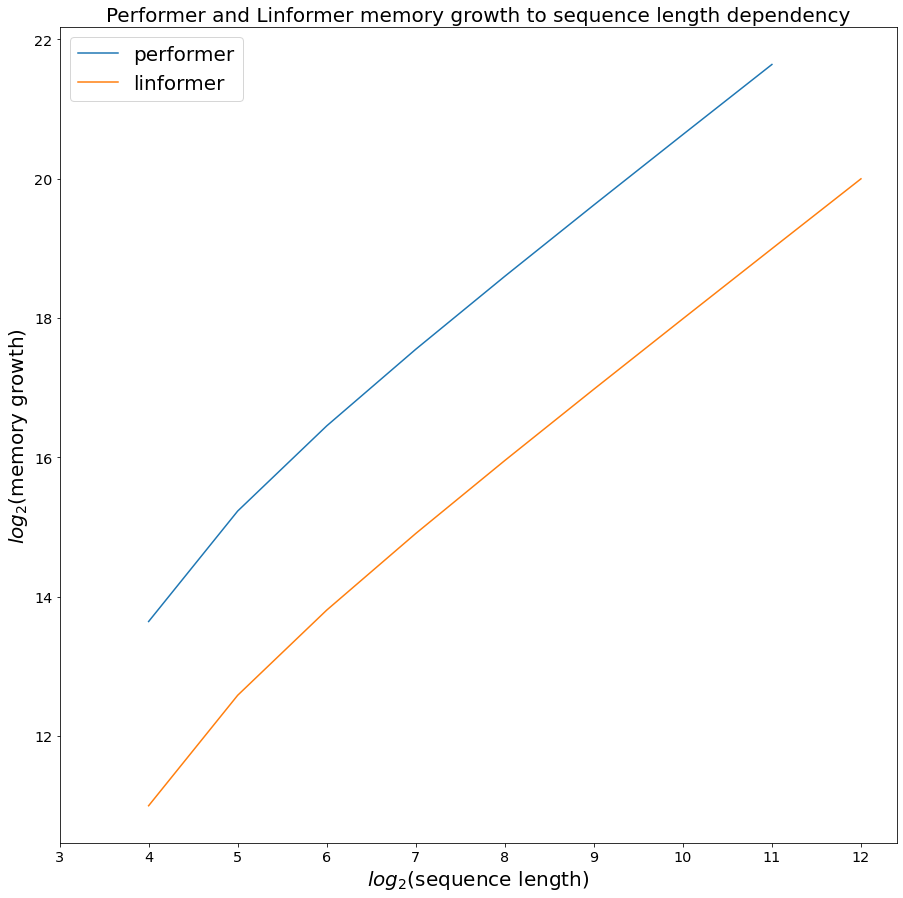

In [24]:
plt.figure(figsize=(15, 15))

plt.title('Performer and Linformer memory growth to sequence length dependency', fontsize=20)
plt.xlabel('$log_2$(sequence length)', fontsize=20)
plt.ylabel('$log_2$(memory growth)', fontsize=20)
plt.plot(np.log2(pf_logs['seq_lens_pf']), np.log2(np.array(pf_logs['memory_pf']) - pf_logs['memory_pf'][0]), label='performer')
#plt.plot(np.log2(tf_logs['seq_lens_tf']), np.log2(np.array(tf_logs['memory_tf'])), label='transformer')
plt.plot(np.log2(lf_logs['seq_lens_lf']), np.log2(np.array(lf_logs['memory_lf']) - lf_logs['memory_lf'][0]), label='linformer')

plt.xticks(np.log2(lf_logs['seq_lens_lf']))

plt.legend(prop={'size': 20})